In [1]:
import numpy as np
import json 
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import DBSCAN
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import glob

# Get Digital Ink from Firestore and save as json files

In [2]:
json_file = glob.glob("*.json")[0]

cred = credentials.Certificate(json_file)
firebase_admin.initialize_app(cred, {
    'projectId': 'digital-pen-746a6',
})

db = firestore.client()

In [3]:
docs = db.collection('ink').stream()

for doc in docs:
    print(f'Saving {doc.id}')

    filename = "../data/uploaded_ink/" + doc.id + ".json"

    with open(filename, 'w') as fp:
        json.dump(doc.to_dict(), fp)

Saving 2x7KWpGxDjsH40bJvsP7
Saving 4DEx1UITVvHf7r8utD9Z
Saving 8Z8Zk6qnS4S74FIpjs3l
Saving 8e05bbCJrJlptvjGm1xa
Saving L1l3xQZg4erNtCnqpgDX
Saving PyPGAyhjuH5OleamLqs7
Saving QVsCfGYE28LsGxDa1417
Saving UJmJnIqlwsNEFfjKelTN
Saving UpjeWjdH7HrpzNvAOnZE
Saving eWYRgAeE4psads07EGIm
Saving i7pJPDAihjRnN4VGZNKG
Saving lbk43HuL5voOJI49qHRm
Saving oIH1HmVVxrJVAXRbwjxk
Saving pwzrwYnnyBRiJaBuWCvZ
Saving wHbt2fWqZGeUgdc54FEG


# Format user uploaded digital ink 


In [4]:
with open("../data/uploaded_ink/2x7KWpGxDjsH40bJvsP7.json") as f:
    ink = json.load(f)

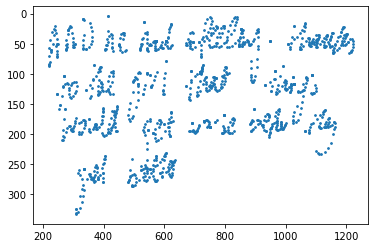

In [5]:
plt.scatter(ink["x"], ink["y"], s = 3)
plt.gca().invert_yaxis()
plt.show()

## Segment ink into individual lines

In [6]:
X = np.swapaxes(np.array([ink["x"], ink["y"], ink["t"]]), 0 , 1)

scaler = StandardScaler().fit(X)

X_norm = normalize(X, axis=0)
X_scaled = scaler.transform(X)

In [10]:
clustering = DBSCAN(eps=0.6, min_samples=5).fit(X_scaled)
labels = clustering.labels_

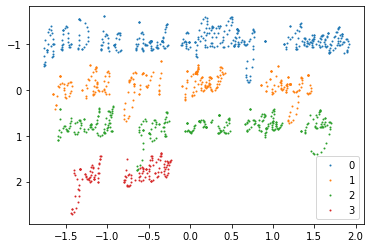

In [11]:
u_labels = np.unique(clustering.labels_)

for i in u_labels:
    plt.scatter(X_scaled[labels == i , 0] , X_scaled[labels == i , 1] , label = i, s = 1)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [12]:
textLines = []

for label in u_labels:
    textLine = {} 
    textLine["x"] = np.array(np.array(ink["x"])[labels == label])
    textLine["y"] = np.array(np.array(ink["y"])[labels == label])
    textLine["t"] = np.array(np.array(ink["t"])[labels == label])
    textLine["p"] = np.array(np.array(ink["p"])[labels == label])

    textLines.append(textLine)

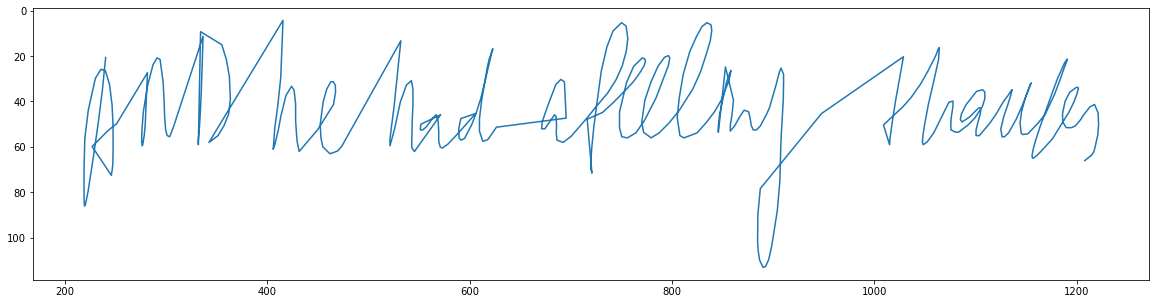

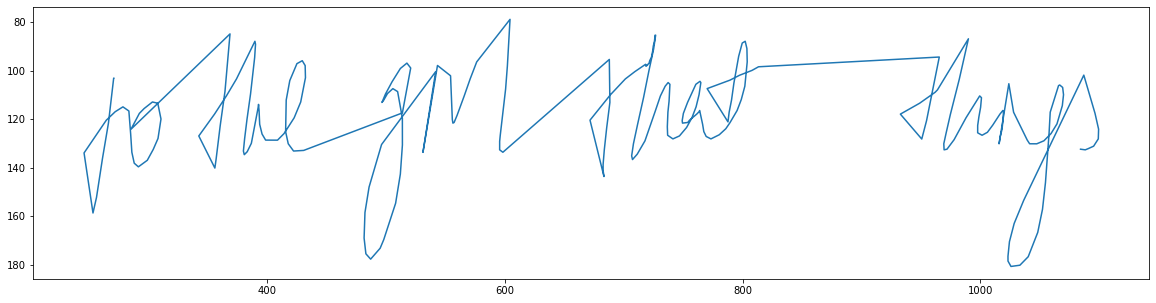

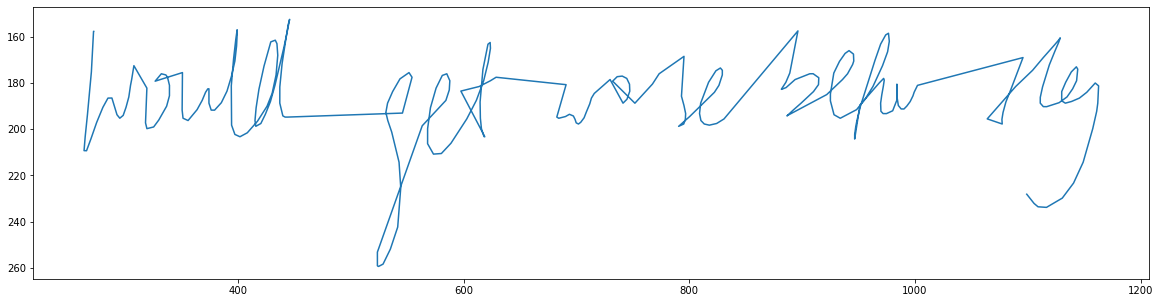

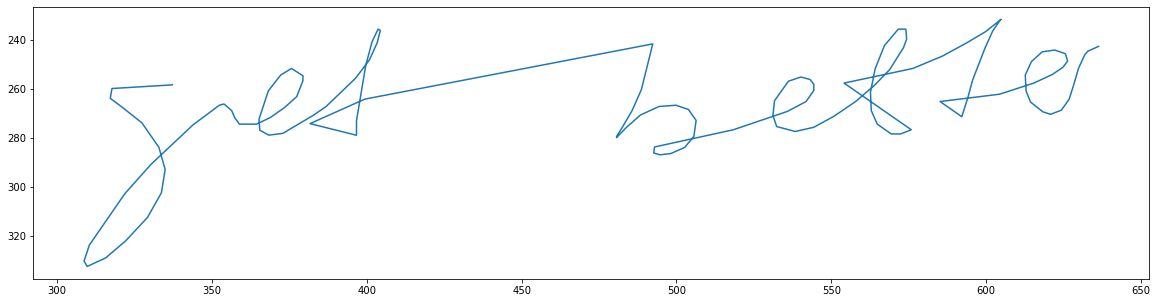

In [13]:
for textLine in textLines:
    plt.figure(figsize=(20,5))
    plt.plot(textLine["x"], textLine["y"])
    plt.gca().invert_yaxis()
    plt.show()

## Splice text lines together into a single line 

In [14]:
merged_textLine = {}
merged_textLine["x"] = textLines[0]["x"]
merged_textLine["y"] = textLines[0]["y"]
merged_textLine["t"] = textLines[0]["t"]
merged_textLine["p"] = textLines[0]["p"]

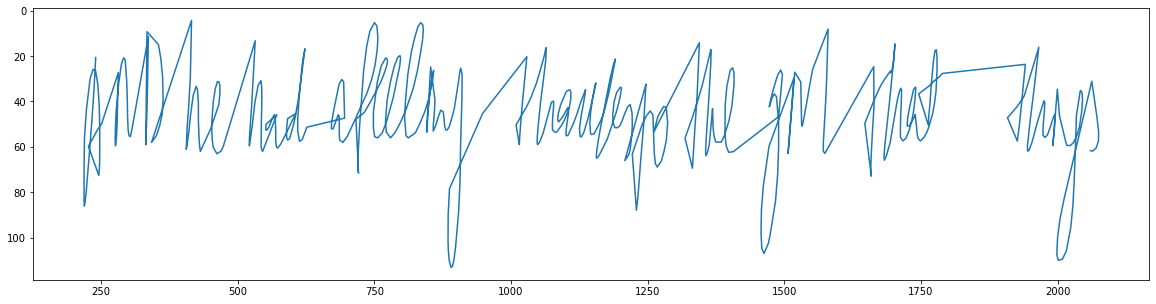

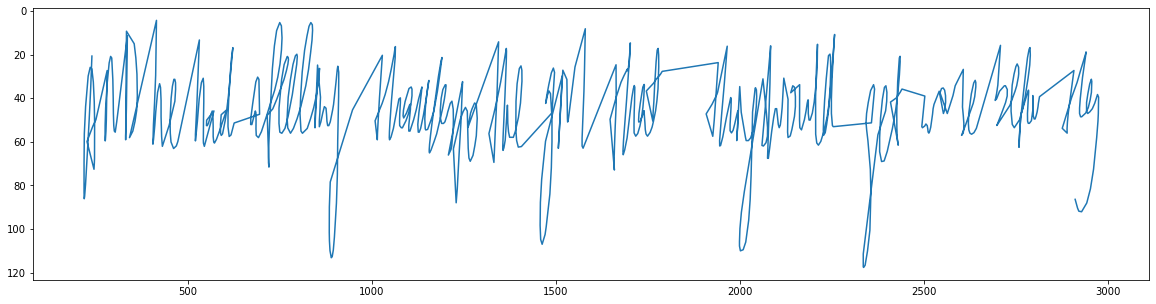

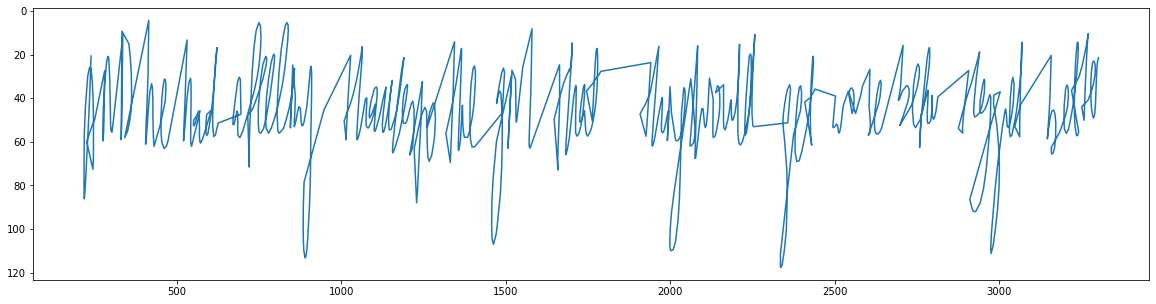

In [15]:
# Determine the y-mean and x-last of the first line 
x_right_last = np.max(textLines[0]["x"])
y_mean_1 = np.mean(textLines[0]["y"])

# For each line after the first 
for i in range(1, len(textLines)):
    textLine = textLines[i]

    # Get the x-start and y_mean of the new line 
    # x_left_curr = np.max(textLine["x"])
    y_mean_curr = np.mean(textLine["y"])
    
    # Add x_right_last to all x values of the next line
    x = textLine["x"]
    x_left_first = np.min(x)
    x_new = x + (x_right_last - x_left_first)
    
    x_right_last = np.max(x_new)
    
    # Minus the difference of means to y values 
    y = textLine["y"]
    y_new = y - y_mean_curr + y_mean_1 
    
    merged_textLine["x"] = np.append(merged_textLine["x"], x_new)
    merged_textLine["y"] = np.append(merged_textLine["y"], y_new)
    merged_textLine["t"] = np.append(merged_textLine["t"], textLine["t"])
    merged_textLine["p"] = np.append(merged_textLine["p"], textLine["p"])
    
    plt.figure(figsize=(20,5))
    plt.plot(merged_textLine["x"], merged_textLine["y"])
    plt.gca().invert_yaxis()
    plt.show()

## Create evenly space time series for single merged textline

In [16]:
x = merged_textLine["x"]
y = merged_textLine["y"]
t = merged_textLine["t"]
p = merged_textLine["p"]

start_t = t[0]
end_t = t[len(t) - 1]

t_filled = np.arange(start_t, end_t, 13)
x_filled = np.interp(t_filled, t, x)
y_filled = np.interp(t_filled, t, y)
p_filled = np.interp(t_filled, t, p)

merged_textLine["x"] = x_filled
merged_textLine["y"] = y_filled
merged_textLine["t"] = t_filled
merged_textLine["p"] = p_filled

print(np.unique(np.diff(merged_textLine["t"])))

[13.]


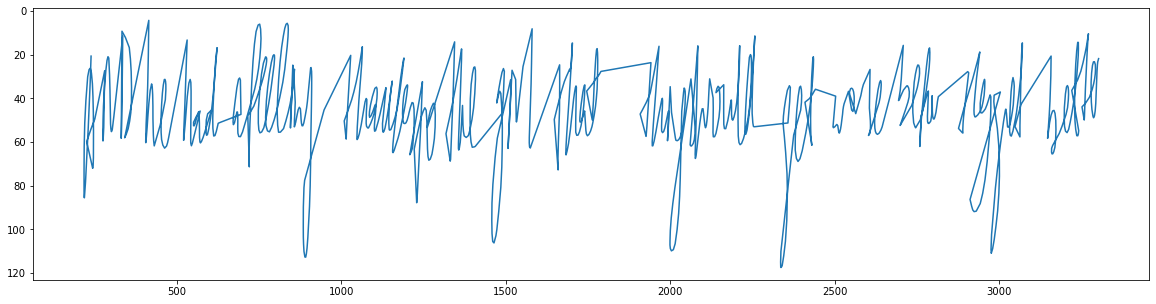

In [17]:
plt.figure(figsize=(20,5))
plt.plot(merged_textLine["x"], merged_textLine["y"])
plt.gca().invert_yaxis()
plt.show()

# Normalise data series 

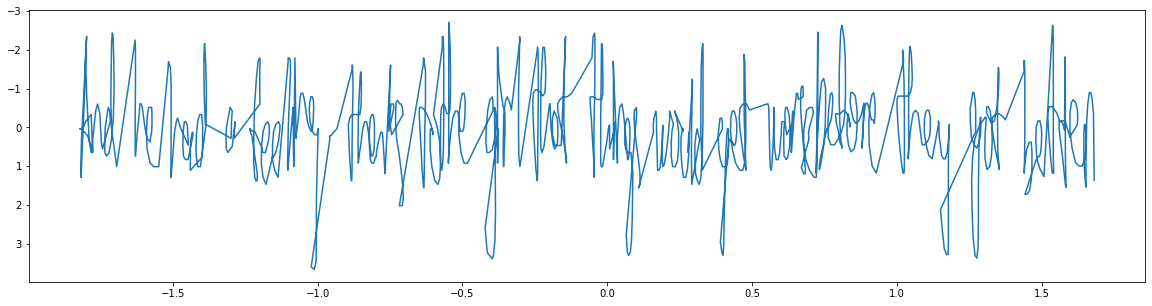

Stored 'digital_ink' (dict)


In [37]:
digital_ink = normalise_textLine(merged_textLine)

plt.figure(figsize=(20,5))
plt.plot(digital_ink["x"], digital_ink["y"])
plt.gca().invert_yaxis()
plt.show()

%store digital_ink